# Gauss-Newton and Levenberg-Marquardt

We will illustrate these methods for nonlinear least squares using the ODE parameter ID problem. This time we will use the solution sensitivity equations to determine the variation of the model output with respect to the parameters. 

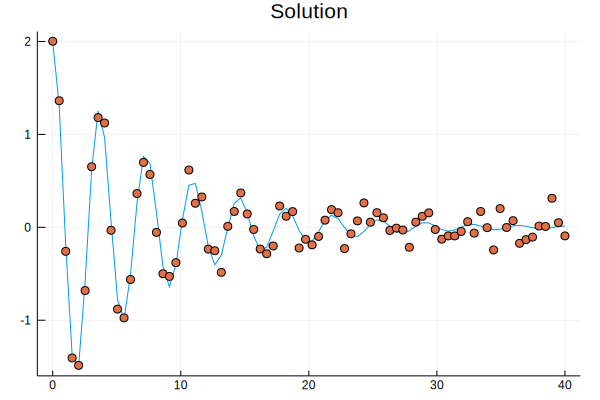

In [1]:
using DifferentialEquations,Plots,LinearAlgebra

# Solution of the ODE model and its sensitivities
function sense(p,t)
    function timederiv(ydot,y,p,t) 
        c,k = p
        u,dudt = y[1:2]
        z,dzdt = y[[3,5]],y[[4,6]]
        ydot[1] = dudt
        ydot[2] = -c*dudt - k*u
        ydot[3] = dzdt[1]
        ydot[4] = -c*dzdt[1] - k*z[1] - dudt
        ydot[5] = dzdt[2]
        ydot[6] = -c*dzdt[2] - k*z[2] - u
    end

    ode = ODEProblem(timederiv,[2.;0;zeros(4)],(0.,40.),p)
    sol = solve(ode,abstol=1e-5,reltol=1e-5)
    u,z = sol.(t,idxs=1),sol.(t,idxs=[3,5])
    return u,hcat(z...)'
end

t = range(0,stop=40,length=80)
exact,z = sense([0.25,3.],t);
data = exact + 0.1*randn(80)
plot(t,exact,leg=false,title="Solution")
scatter!(t,data,leg=false)

The columns of `z` are perturbations of $u$ with respect to $c$ and $k$ (evaluated at the selected times).

size(z) = (80, 2)


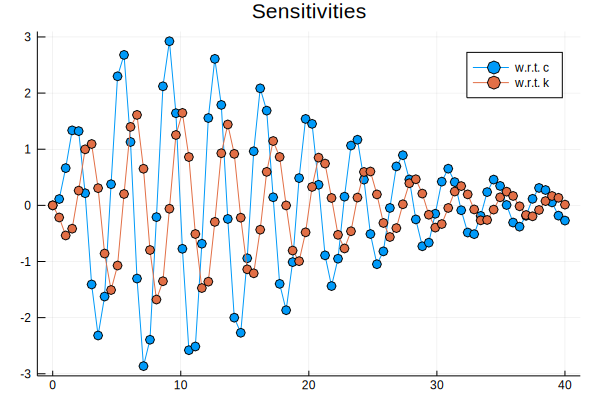

In [2]:
@show size(z)
plot(t,z,m=:o,label=["w.r.t. c","w.r.t. k"],title="Sensitivities")

As before, the residual or 'misfit' vector $F(x)$ is the difference between model output and the data values, as a function of the parameter vector $x=[c,k]$. The 2-norm of $F$ is the objective of the minimization.

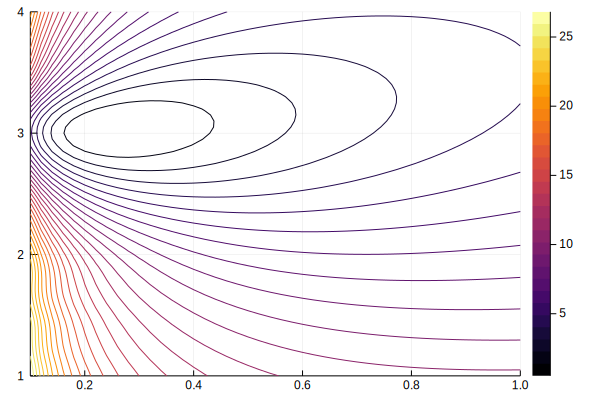

In [3]:
misfit(p) = sense(p,t)[1] - data
obj(x) = norm(misfit(x))^2/2
contour(0.1:0.02:1,1:0.05:4,(c,k)->obj([c,k]),levels=30)

As a result, the second output from `sense` (like `z` above) is just the Jacobian matrix $J=F'$ of $F$. Furthermore, the gradient of the scalar objective function is $J(x)^TF(x)$.

In [4]:
function misfit(p)
    u,J = sense(p,t)
    return u-data,J
end

F,J = misfit([.25,3.])
f,g = F'*F/2,J'*F

(0.5034963321503132, [0.0925365, -0.756585])

Here is where we deviate from a true Newton method. Calculuating the Hessian of the objective requires solving an even larger ODE system. Instead, we can approximate the Hessian using $J^TJ$. If the residual of the problem is small (or the curvature of the objective is small), this should be adequate. That is the *Gauss-Newton* method.

But note that if we define the GN iteration step as $s=-(J^TJ)^{-1}(J^TF)$, we have solved the normal equations for the linear least squares problem $Js\approx -F$. That is, GN solves the nonlinear least squares problem as a sequence of linear least squares problems.

In [5]:
xc = [1.,3.2]

for k = 1:20
    F,J = misfit(xc)
    s = -(J\F)
    xc += s
    @show xc
end

xc = [-0.539608, 2.7376]
xc = [-0.487692, 2.72565]
xc = [-0.435523, 2.71501]
xc = [-0.383045, 2.70571]
xc = [-0.330178, 2.69774]
xc = [-0.2768, 2.69112]
xc = [-0.222729, 2.68589]
xc = [-0.167654, 2.68207]
xc = [-0.111006, 2.67975]
xc = [-0.0516314, 2.6792]
xc = [0.0130322, 2.68157]
xc = [0.0886352, 2.6923]
xc = [0.183497, 2.73533]
xc = [0.278771, 2.87327]
xc = [0.273564, 3.03487]
xc = [0.248745, 3.01448]
xc = [0.250243, 3.01774]
xc = [0.250205, 3.01767]
xc = [0.250205, 3.01768]
xc = [0.250205, 3.01768]


Even with a not-bad initial guess, the convergence in this example was lackluster for many iterations before getting a clue. This is not unusual with GN, which needs modifications to be useful. 

## Levenberg-Marquardt

LM can be thought of as globalizing the convergence of GN. We introduce a damping parameter that gives a descent direction when the GN step would fail. As we get close to the minimizer, the damping dies out, returning us to fast asymptotic convergence. 

Here's the previous example using LM.

In [6]:
xc = [1.,3.2]

for k = 1:10
    F,J = misfit(xc)
    μ = norm(F)
    @show (xc,μ)
    s = [J;μ*I] \ [-F;0;0]
    xc += s
end

(xc, μ) = ([1.0, 3.2], 2.888545978737929)
(xc, μ) = ([0.673975, 3.26299], 2.3599338965921692)
(xc, μ) = ([0.297366, 3.14745], 1.284926270588382)
(xc, μ) = ([0.261608, 2.99773], 1.0144200735839721)
(xc, μ) = ([0.250733, 3.01824], 0.9968399395347393)
(xc, μ) = ([0.250206, 3.01766], 0.9968180083548902)
(xc, μ) = ([0.250205, 3.01768], 0.9968180047873226)
(xc, μ) = ([0.250205, 3.01768], 0.9968180047841444)
(xc, μ) = ([0.250205, 3.01768], 0.9968180047841152)
(xc, μ) = ([0.250205, 3.01768], 0.9968180047841153)


That was a lot more direct. Convergence is obtained for a fairly wide variety of initial guesses.

In [7]:
xc = [0.05,6]

for k = 1:50
    F,J = misfit(xc)
    μ = norm(F)
    @show (xc,μ)
    s = [J;μ*I] \ [-F;0;0]
    xc += s
end

(xc, μ) = ([0.05, 6.0], 9.265571595733332)
(xc, μ) = ([0.140866, 6.00282], 6.635261662681609)
(xc, μ) = ([0.289655, 6.01287], 5.297446222840165)
(xc, μ) = ([0.546996, 6.02067], 4.430117779825345)
(xc, μ) = ([0.848893, 5.98851], 3.9379238806752777)
(xc, μ) = ([1.08312, 5.92519], 3.706931174583241)
(xc, μ) = ([1.24765, 5.85423], 3.5923607534864415)
(xc, μ) = ([1.36408, 5.78466], 3.5289683446600377)
(xc, μ) = ([1.4479, 5.71882], 3.4903806364470773)
(xc, μ) = ([1.50881, 5.6569], 3.4648996941002372)
(xc, μ) = ([1.553, 5.59848], 3.446801657236017)
(xc, μ) = ([1.58454, 5.54301], 3.433045062967012)
(xc, μ) = ([1.60624, 5.48991], 3.42190336313612)
(xc, μ) = ([1.62007, 5.43868], 3.4123396861208866)
(xc, μ) = ([1.62748, 5.38887], 3.403700568093641)
(xc, μ) = ([1.62953, 5.34008], 3.3955544427353215)
(xc, μ) = ([1.62703, 5.29195], 3.3876026696141004)
(xc, μ) = ([1.62059, 5.24416], 3.379627937504647)
(xc, μ) = ([1.61068, 5.1964], 3.3714618539308177)
(xc, μ) = ([1.59767, 5.1484], 3.3629648000575814)


Much better heuristics are available for choosing $\mu$. But you can see how LM keeps you in the game until Newton can take over.